## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)                
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
PRE_ACTIVATE = [True, False]


In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batchSize in BATCH_SIZE:
    for preActivate in PRE_ACTIVATE:
        keras.backend.clear_session()
        print(f"batchSize: {batchSize}, preActivate: {preActivate}")
        model = build_mlp(input_shape=x_train.shape[1:], pre_activate=preActivate)
        model.summary()                
        
        optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchSize, 
              validation_data=(x_test, y_test), 
              shuffle=True)        
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]        

        exp_name_tag = "batchSize: %s, pre_activeate: %s" %(str(batchSize), preActivate)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

  

batchSize: 2, preActivate: True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)             

Epoch 42/50
25000/25000 [==============================] - 235s 9ms/step - loss: 2.2840 - accuracy: 0.1313 - val_loss: 3.4442 - val_accuracy: 0.1617
Epoch 43/50
25000/25000 [==============================] - 237s 9ms/step - loss: 2.2843 - accuracy: 0.1320 - val_loss: 3.0544 - val_accuracy: 0.1624
Epoch 44/50
25000/25000 [==============================] - 227s 9ms/step - loss: 2.2836 - accuracy: 0.1307 - val_loss: 3.1684 - val_accuracy: 0.1568
Epoch 45/50
25000/25000 [==============================] - 205s 8ms/step - loss: 2.2833 - accuracy: 0.1318 - val_loss: 3.3061 - val_accuracy: 0.1582
Epoch 46/50
25000/25000 [==============================] - 206s 8ms/step - loss: 2.2823 - accuracy: 0.1320 - val_loss: 3.0433 - val_accuracy: 0.1544
Epoch 47/50
25000/25000 [==============================] - 190s 8ms/step - loss: 2.2840 - accuracy: 0.1322 - val_loss: 3.0609 - val_accuracy: 0.1607
Epoch 48/50
25000/25000 [==============================] - 190s 8ms/step - loss: 2.2840 - accuracy: 0.1333

25000/25000 [==============================] - 133s 5ms/step - loss: 2.2387 - accuracy: 0.1624 - val_loss: 487.3501 - val_accuracy: 0.1927
Epoch 33/50
25000/25000 [==============================] - 133s 5ms/step - loss: 2.2324 - accuracy: 0.1688 - val_loss: 593.3855 - val_accuracy: 0.1886
Epoch 34/50
25000/25000 [==============================] - 151s 6ms/step - loss: 2.2326 - accuracy: 0.1684 - val_loss: 171.4051 - val_accuracy: 0.1906
Epoch 35/50
25000/25000 [==============================] - 161s 6ms/step - loss: 2.2272 - accuracy: 0.1686 - val_loss: 121.0365 - val_accuracy: 0.1986
Epoch 36/50
25000/25000 [==============================] - 157s 6ms/step - loss: 2.2272 - accuracy: 0.1702 - val_loss: 237.6362 - val_accuracy: 0.1927
Epoch 37/50
25000/25000 [==============================] - 168s 7ms/step - loss: 2.2242 - accuracy: 0.1747 - val_loss: 152.2394 - val_accuracy: 0.2054
Epoch 38/50
25000/25000 [==============================] - 164s 7ms/step - loss: 2.2283 - accuracy: 0.1716

3125/3125 [==============================] - 18s 6ms/step - loss: 0.8193 - accuracy: 0.7103 - val_loss: 1.5291 - val_accuracy: 0.5341
Epoch 24/50
3125/3125 [==============================] - 18s 6ms/step - loss: 0.7962 - accuracy: 0.7184 - val_loss: 1.6901 - val_accuracy: 0.5009
Epoch 25/50
3125/3125 [==============================] - 18s 6ms/step - loss: 0.7807 - accuracy: 0.7227 - val_loss: 1.5447 - val_accuracy: 0.5198
Epoch 26/50
3125/3125 [==============================] - 18s 6ms/step - loss: 0.7612 - accuracy: 0.7304 - val_loss: 1.7865 - val_accuracy: 0.4905
Epoch 27/50
3125/3125 [==============================] - 18s 6ms/step - loss: 0.7569 - accuracy: 0.7315 - val_loss: 1.6950 - val_accuracy: 0.5059
Epoch 28/50
3125/3125 [==============================] - 18s 6ms/step - loss: 0.7293 - accuracy: 0.7398 - val_loss: 1.8505 - val_accuracy: 0.4914
Epoch 29/50
3125/3125 [==============================] - 19s 6ms/step - loss: 0.7188 - accuracy: 0.7443 - val_loss: 1.8125 - val_accurac

Epoch 15/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.3255 - accuracy: 0.5318 - val_loss: 1.3690 - val_accuracy: 0.5137
Epoch 16/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.3157 - accuracy: 0.5323 - val_loss: 1.4519 - val_accuracy: 0.4789
Epoch 17/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.3152 - accuracy: 0.5321 - val_loss: 1.4181 - val_accuracy: 0.4992
Epoch 18/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.2995 - accuracy: 0.5394 - val_loss: 1.4384 - val_accuracy: 0.4945
Epoch 19/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.2840 - accuracy: 0.5436 - val_loss: 1.3887 - val_accuracy: 0.5092
Epoch 20/50
3125/3125 [==============================] - 21s 7ms/step - loss: 1.2776 - accuracy: 0.5489 - val_loss: 1.3879 - val_accuracy: 0.5100
Epoch 21/50
3125/3125 [==============================] - 20s 6ms/step - loss: 1.2676 - accuracy: 0.5499 - val_loss: 1.3957 -

Epoch 7/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0806 - accuracy: 0.6202 - val_loss: 1.4902 - val_accuracy: 0.4816
Epoch 8/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0330 - accuracy: 0.6352 - val_loss: 1.4150 - val_accuracy: 0.5028
Epoch 9/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9832 - accuracy: 0.6539 - val_loss: 1.5260 - val_accuracy: 0.4783
Epoch 10/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9417 - accuracy: 0.6677 - val_loss: 1.5104 - val_accuracy: 0.4873
Epoch 11/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8981 - accuracy: 0.6811 - val_loss: 1.5815 - val_accuracy: 0.4768
Epoch 12/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8649 - accuracy: 0.6959 - val_loss: 1.4810 - val_accuracy: 0.5145
Epoch 13/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8205 - accuracy: 0.7106 - val_loss: 1.6383 - va

Epoch 1/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7371 - accuracy: 0.3875 - val_loss: 1.6176 - val_accuracy: 0.4203
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5432 - accuracy: 0.4512 - val_loss: 1.5619 - val_accuracy: 0.4501
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4635 - accuracy: 0.4796 - val_loss: 1.6128 - val_accuracy: 0.4262
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4206 - accuracy: 0.4924 - val_loss: 1.5157 - val_accuracy: 0.4591
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3829 - accuracy: 0.5071 - val_loss: 1.4436 - val_accuracy: 0.4881
Epoch 6/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3557 - accuracy: 0.5205 - val_loss: 1.5934 - val_accuracy: 0.4501
Epoch 7/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3345 - accuracy: 0.5246 - val_loss: 1.5253 - val_ac

Epoch 1/50
391/391 [==============================] - 5s 11ms/step - loss: 1.7276 - accuracy: 0.3915 - val_loss: 1.6277 - val_accuracy: 0.4275
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 1.4421 - accuracy: 0.4915 - val_loss: 1.5035 - val_accuracy: 0.4623
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 1.3188 - accuracy: 0.5366 - val_loss: 1.5728 - val_accuracy: 0.4398
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 1.2281 - accuracy: 0.5720 - val_loss: 1.6379 - val_accuracy: 0.4273
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 1.1435 - accuracy: 0.6024 - val_loss: 1.5067 - val_accuracy: 0.4704
Epoch 6/50
391/391 [==============================] - 4s 11ms/step - loss: 1.0690 - accuracy: 0.6279 - val_loss: 1.5016 - val_accuracy: 0.4643
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 1.0004 - accuracy: 0.6541 - val_loss: 1.7058 - val_accuracy: 0.4389

Epoch 1/50
391/391 [==============================] - 5s 11ms/step - loss: 1.7704 - accuracy: 0.3884 - val_loss: 1.6513 - val_accuracy: 0.4091
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 1.4981 - accuracy: 0.4740 - val_loss: 1.5659 - val_accuracy: 0.4497
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 1.3951 - accuracy: 0.5082 - val_loss: 1.5737 - val_accuracy: 0.4499
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 1.3227 - accuracy: 0.5353 - val_loss: 1.6191 - val_accuracy: 0.4453
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 1.2670 - accuracy: 0.5531 - val_loss: 1.4557 - val_accuracy: 0.4867
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 1.2107 - accuracy: 0.5734 - val_loss: 1.4961 - val_accuracy: 0.4754
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 1.1649 - accuracy: 0.5878 - val_loss: 1.5330 - val_accuracy: 0.4593

Epoch 1/50
196/196 [==============================] - 4s 16ms/step - loss: 1.8493 - accuracy: 0.3458 - val_loss: 1.7622 - val_accuracy: 0.3990
Epoch 2/50
196/196 [==============================] - 3s 14ms/step - loss: 1.5403 - accuracy: 0.4578 - val_loss: 1.5694 - val_accuracy: 0.4424
Epoch 3/50
196/196 [==============================] - 3s 14ms/step - loss: 1.4254 - accuracy: 0.4986 - val_loss: 1.5478 - val_accuracy: 0.4595
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3372 - accuracy: 0.5331 - val_loss: 1.4771 - val_accuracy: 0.4798
Epoch 5/50
196/196 [==============================] - 3s 14ms/step - loss: 1.2668 - accuracy: 0.5589 - val_loss: 1.4669 - val_accuracy: 0.4886
Epoch 6/50
196/196 [==============================] - 3s 14ms/step - loss: 1.2003 - accuracy: 0.5860 - val_loss: 1.4393 - val_accuracy: 0.4947
Epoch 7/50
196/196 [==============================] - 3s 14ms/step - loss: 1.1393 - accuracy: 0.6074 - val_loss: 1.4957 - val_accuracy: 0.4711

Epoch 1/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8660 - accuracy: 0.3607 - val_loss: 1.7336 - val_accuracy: 0.3859
Epoch 2/50
196/196 [==============================] - 3s 13ms/step - loss: 1.5493 - accuracy: 0.4576 - val_loss: 1.6352 - val_accuracy: 0.4133
Epoch 3/50
196/196 [==============================] - 3s 13ms/step - loss: 1.4505 - accuracy: 0.4916 - val_loss: 1.6219 - val_accuracy: 0.4342
Epoch 4/50
196/196 [==============================] - 3s 13ms/step - loss: 1.3764 - accuracy: 0.5195 - val_loss: 1.5367 - val_accuracy: 0.4544
Epoch 5/50
196/196 [==============================] - 3s 13ms/step - loss: 1.3162 - accuracy: 0.5387 - val_loss: 1.4684 - val_accuracy: 0.4833
Epoch 6/50
196/196 [==============================] - 3s 13ms/step - loss: 1.2658 - accuracy: 0.5577 - val_loss: 1.5369 - val_accuracy: 0.4671
Epoch 7/50
196/196 [==============================] - 3s 13ms/step - loss: 1.2189 - accuracy: 0.5746 - val_loss: 1.4981 - val_accuracy: 0.4781

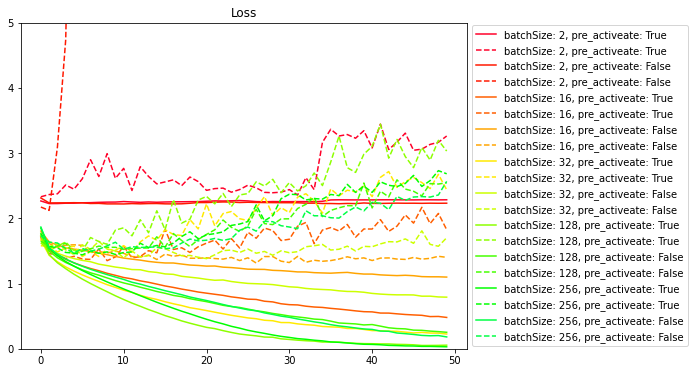

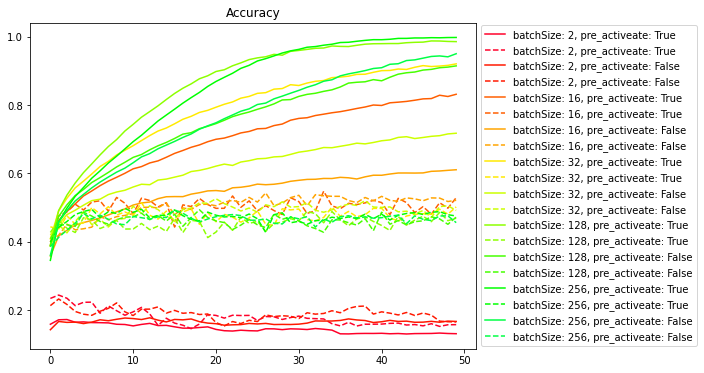

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [ scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
"""Code Here
將結果繪出
"""

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()